SHAP를 이용해 CO2RR 공정 데이터를 MLP로 도출한 결과를 분석하자

step1. 라이브러리 정리

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


step2. 엑셀 파일 불러오기

In [2]:
# 엑셀 데이터 로드 
filepath = r"C:\Users\kepco201\Desktop\SHAP_Project\25.01.14_CO2RR_GSA.xlsx"
excel_file = pd.ExcelFile(filepath) 
df_in  = pd.read_excel(excel_file, sheet_name='Input')
df_out = pd.read_excel(excel_file, sheet_name='Output')

step3.Outlier 제거 / 전체 데이터의 10% 이내로 극소량만 제거

In [3]:
# 이상치(Outlier) 제거 (IQR 방식) ---
print(f"이상치 제거 전 데이터 수: {len(df_in)} 개")   # len(df_in) 을 통해 이상치 제거 전 데이터 길이(개수) 출력


def remove_outliers_iqr(df_in, df_out):              # outlier 제거 함수 정의
    
    combined_df = pd.concat([df_in, df_out], axis=1) # pd.concat = 2개를 합치기 // 입력 변수(X)와 출력 변수(y)를 합쳐서 전체 데이터프레임 생성 // x랑 y를 한번에 고려
                                                     # axis = 1 --- 오른쪽으로 합치기 --- 데이터 구조를 보면 예쁘게 정리가 된다
    
    numeric_cols = combined_df.select_dtypes(include=np.number).columns  # .select_dtypes 를 통해 특정 열만 출력 outlier 를 탐지할 숫자형 컬럼만 선택
                                    # numeric_cols = 숫자로만 구성된 열들의 이름 리스트 (.colums = 그 열의 이름을 리스트로 출력)

    # 각 컬럼에 대해 이상치 경계 계산 
    Q1 = combined_df[numeric_cols].quantile(0.25)   # .quantile(0.25) = 데이터를 오름차순으로 정렬했을 떄 하위 25% 지점 
    Q3 = combined_df[numeric_cols].quantile(0.75)   # .quantile(0.75) = 데이터를 오름차순으로 정렬했을 떄 상위 25% 지점 
    IQR = Q3 - Q1 # IQR은 대략 상위 25% - 상위75% = 중간정도의 값에 해당
    
    lower_bound = Q1 - 6 * IQR  # 보통은 1.5* IQR을 진행하지만 최대한 삭제되는 데이터가 적도록 진행
    upper_bound = Q3 + 6 * IQR
    

    # 밑의 줄은 공부를 더 해보자
    # 모든 컬럼에 대해 정상 범위 내에 있는 데이터만 True로 표시
    # (row의 어떤 컬럼이라도 이상치면 해당 row 전체가 False가 됨)
    condition = ~((combined_df[numeric_cols] < lower_bound) | (combined_df[numeric_cols] > upper_bound)).any(axis=1)
    

    # 정상 범위에 있는 데이터만 필터링
    df_in_no_outliers = df_in[condition]
    df_out_no_outliers = df_out[condition]
    
    return df_in_no_outliers, df_out_no_outliers



# 3. 함수를 사용하여 이상치 제거
#    이전에 결측치를 제거한 df_in_cleaned, df_out_cleaned를 사용합니다.
df_in_final, df_out_final = remove_outliers_iqr(df_in, df_out)


# 4. 이상치 제거 후 남은 데이터 개수 확인
removed_count = len(df_in) - len(df_in_final)  # 몇 개 지웠는지 세기
print(f"이상치 제거 후 데이터 수: {len(df_in_final)} 개 ({removed_count} 개 제거됨)")
print("이상치 제거 완료 ")


# 이제 'df_in_final'과 'df_out_final'을 사용하자





이상치 제거 전 데이터 수: 2501 개
이상치 제거 후 데이터 수: 2378 개 (123 개 제거됨)
이상치 제거 완료 


step4. outlier 제거 후 X와 y 정의

In [4]:
# 입력 변수(X) 선택
# 모델이 '총 필요 에너지'를 예측하는 데 사용할 정보(컬럼)들을 선택
X = df_in_final[[
    "Current density (mA/cm2)", 
    "Faradaic efficiency (%)", 
    "CO coversion",
    "Voltage (V)", 
    "Electricity cost ($/kWh)", 
    "Membrain cost ($/m2)",
    "Catpure energy (GJ/ton)", 
    "Crossover rate"
]].values



predicting = "Required energy_total (MJ/kgCO)" # 다른 output 변수 보고싶으면 이거 보면 됨 # Required energy_total (MJ/kgCO) # MSP ($/kgCO)
###### 이거를 수정해서 다른 output도 보자

y = df_out_final[predicting].values.reshape(-1, 1)   # df_out_final[] 는 pandas datatframe이기에 이것을 skitlearn 이나 Keras 형태로 바꾸기 -- 그래야 
                                                     # .values 를 통해 Numpy 배열로 변환 (값만 뽑기 때문) # 그 후에 reshape(-1.1) 을 통해 
                                                     # .reshape()을 이용해 열 1개




print(X)
print("====================")
print(y)


[[1.97379048e+03 9.73836465e-01 3.72471012e-02 ... 2.89292283e+02
  3.14514194e+00 1.49940024e-01]
 [1.95631747e+03 9.63060776e-01 5.54118353e-02 ... 2.92153805e+02
  3.24190324e+00 2.49900040e-01]
 [1.93884446e+03 9.52285086e-01 7.35765694e-02 ... 2.95015327e+02
  3.33866453e+00 3.49860056e-01]
 ...
 [1.61155538e+02 5.37714914e-01 5.36423431e-01 ... 3.38318006e+02
  4.66133547e+00 1.65013994e+00]
 [1.43682527e+02 5.26939224e-01 5.54588165e-01 ... 3.41179528e+02
  4.75809676e+00 1.75009996e+00]
 [1.26209516e+02 5.16163535e-01 5.72752899e-01 ... 3.44041050e+02
  4.85485806e+00 1.85005998e+00]]
[[137.83276055]
 [ 97.65612097]
 [ 77.61576681]
 ...
 [ 47.34602399]
 [ 50.01962389]
 [ 53.6021701 ]]


step5. train_set, valadation_set, test_set 만들기 (64:16:20) 

In [5]:
# 1단계: 먼저 train+val과 test로 분할 (80:20)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 2단계: train+val을 train과 val로 분할 (64:16, 전체 대비)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)  # 0.2 × 0.8 = 0.16 (전체의 16%)


# 최종 비율 확인
# (X[:,0])~(X[:,7]) 에 각각의 입력변수들의 값들이 각각 저장됨



print(X_val)
print(f"전체 데이터셋 크기: {len(X)}")
print(f"훈련셋 크기: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"검증셋 크기: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")  
print(f"테스트셋 크기: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

[[6.39764094e+02 8.75483806e-01 2.88958417e-01 ... 3.31531387e+02
  3.22830868e+00 3.92243103e-01]
 [1.92303079e+02 6.42141144e-01 1.31609356e-01 ... 3.46927896e+02
  3.07636945e+00 1.13674530e+00]
 [1.80057977e+03 5.59070372e-01 2.64424230e-01 ... 3.34950020e+02
  3.93042783e+00 1.81567373e+00]
 ...
 [1.23612555e+03 6.04132347e-01 1.88462615e-01 ... 2.99953352e+02
  4.33506597e+00 1.76129548e+00]
 [1.70637745e+03 6.59774090e-01 1.61333467e-01 ... 3.05549780e+02
  3.23470612e+00 1.97241104e+00]
 [1.03100760e+03 8.20625750e-01 1.96483407e-01 ... 3.39052379e+02
  3.72091164e+00 1.93482607e+00]]
전체 데이터셋 크기: 2378
훈련셋 크기: 1521 (64.0%)
검증셋 크기: 381 (16.0%)
테스트셋 크기: 476 (20.0%)


step6. 데이터 전처리(0.1~0.9로 scaling)

In [6]:
# 중요: 훈련 데이터(X_train, y_train)의 최소/최대값을 기준으로 스케일러를 학습(fit)하고,
# 이 기준으로 모든 데이터셋(train, val, test)을 동일하게 변환합니다.
# 이렇게 해야 테스트 과정에서 미래 정보(테스트셋의 최소/최대값)가 모델에 유출되는 것을 막을 수 있다.
# validation dataset이나 test data로 스케일링을 할 시 데이터 누수 발생 가능

from sklearn.preprocessing import MinMaxScaler
import numpy as np



# 1. MinMaxScaler 객체 생성 --- 범위를 0.1~0.9로 재설정
scaler_X = MinMaxScaler(feature_range=(0.1, 0.9))
scaler_y = MinMaxScaler(feature_range=(0.1, 0.9))




X_train_scaled = scaler_X.fit_transform(X_train) # 훈련 데이터로 스케일러 학습 및 변환 (fit_transform)
Y_train_scaled= scaler_y.fit_transform(y_train) # X_train의 각 변수(컬럼)별로 최소값은 0, 최대값은 1이 되도록 변환됩니다.

# 3. 학습된 스케일러로 검증 및 테스트 데이터 변환 (transform)
# X_train의 기준으로 나머지 데이터들을 변환합니다.
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

Y_val_scaled = scaler_y.transform(y_val)   # y_val 과 y_test 도 y_train 의 정규분포를 따라 변환된다
Y_test_scaled = scaler_y.transform(y_test)



# X_train_norm 은 [[x0~x7], [x0~x7],....,[x0~x7]] 에서 각 x0~x7은 각 열마다 각각 범위가 0~1로 범위가 변환됨
# 이 변환된 정도를 X_val_norm 과 X_test_norm도 적용받음

print("\n--- 데이터 분할 및 전처리 최종 결과 ---")
print(f"훈련 데이터 형태: X({X_train_scaled.shape}), Y({Y_train_scaled.shape})")
print(f"검증 데이터 형태: X({X_val_scaled.shape}), Y({Y_val_scaled.shape})")
print(f"테스트 데이터 형태: X({X_test_scaled.shape}), Y({Y_test_scaled.shape})")




print("\n\n 스케일링된 훈련 데이터(X_train_scaled) 샘플:")

feature_names = [
    "Current density (mA/cm2)", "Faradaic efficiency (%)", "CO coversion",
    "Voltage (V)", "Electricity cost ($/kWh)", "Membrain cost ($/m2)",
    "Catpure energy (GJ/ton)", "Crossover rate"
]

 

print(pd.DataFrame(X_train_scaled, columns=feature_names).head())


--- 데이터 분할 및 전처리 최종 결과 ---
훈련 데이터 형태: X((1521, 8)), Y((1521, 1))
검증 데이터 형태: X((381, 8)), Y((381, 1))
테스트 데이터 형태: X((476, 8)), Y((476, 1))


 스케일링된 훈련 데이터(X_train_scaled) 샘플:
   Current density (mA/cm2)  Faradaic efficiency (%)  CO coversion  \
0                  0.602348                 0.823169      0.516976   
1                  0.800891                 0.874710      0.772435   
2                  0.886073                 0.797559      0.553894   
3                  0.627611                 0.848459      0.150762   
4                  0.220810                 0.139056      0.843634   

   Voltage (V)  Electricity cost ($/kWh)  Membrain cost ($/m2)  \
0     0.807803                  0.575070              0.115366   
1     0.869588                  0.791797              0.104802   
2     0.180352                  0.547219              0.864146   
3     0.773870                  0.273509              0.866066   
4     0.540176                  0.612525              0.544018   

   Catp

step7. MLP 구조 설계 및 여러 신경망 층 구조에 대한 GridSearchCV 진행을 통해 최적 구조 찾기

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from scikeras.wrappers import KerasRegressor  # scikeras 권장
from sklearn.model_selection import GridSearchCV






# 1. 모델 생성 함수 정의 / units1 = hidden layer 1층 / units2 = hidden layer 2층
def create_ann_model(units1=32, units2=16, activation='relu'):     
    model = Sequential([
        Input(shape=(8,)),             # 입력 특성 8개
        Dense(units1, activation=activation),  # hidden layer (units1)개
        Dense(units2, activation=activation),  # 입력 특성 8개 (units2)개
        Dense(1, activation='linear')
    ])
    
    
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',   # loss function = MSE -- 이것에 따라 학습의 방향이 결정됨
        metrics=['mean_absolute_error']  # 학습에 영향은 주지 않지만 그냥 평가지표 MAE
    )
    return model  


# 2. 래퍼 정의 (scikeras)     
regressor = KerasRegressor(    # Keras로 만든 딥러닝 모델을 Scikit-learn의 회귀(Regressor) 모델처럼 보이게 포장 --- scikit-learn의 최적의 units 수 등을 찾는 gridsearchCV 같은 기능을 쓰기 가능
    model=create_ann_model,    
    verbose=0                  # verbose = 0 --- 모델 훈련과정 출력 X // 1 -- 출력  //  2 -- epoch 끝날때마다 출력
)



# 3. 모델 생성 및 구조 확인
# Required energy_total 예측 모델
#ann_model = create_ann_model()

# 모델의 구조를 요약하여 출력합니다.
#print("--- 'Required energy_total' 예측 모델 구조 ---")
#ann_model.summary()







# 4. GridSearchCV를 통해 검사할 놈들 결정 .. 나중에 GridSearchCV.fit()을 통해 학습 예정
grid = GridSearchCV(
    estimator = KerasRegressor( model=create_ann_model,verbose=0),   # Keras로 만든 딥러닝 모델을 Scikit-learn의 회귀(Regressor) 모델처럼 보이게 포장 --- scikit-learn의 최적의 units 수 등을 찾는 gridsearchCV 같은 기능을 쓰기 가능    
                                                                     # verbose = 0 --- 모델 훈련과정 출력 X // 1 -- 출력  //  2 -- epoch 끝날때마다 출력
    param_grid= {
        'model__units1': [16, 32],                    # hidden layer 1층 뉴런수 
        'model__units2': [8, 16],                     # hidden layer 2층 뉴런수
        'model__activation': ['relu', 'tanh'],        # 활성화함수
        'batch_size': [32],                           # 배치 사이즈
        'epochs': [100],                              # 학습 epoch 수  --- 총 학습 수 = 2*2*2 = 8 이다.
    },
    cv=3,                              # cross validation 3번 (3 fold validation)  --- 총 학습 수 = 8*3 = 24
    scoring='neg_mean_squared_error',  # -MSE가 높을수록 좋다고 설정
    n_jobs=-1                          # 사용 가능한 CPU 코어 전부 사용하라는 의미
)



grid_result = grid.fit(X_train_scaled, Y_train_scaled)   # GridSearchCV.fit() 실행하기 -- 여러 모델 구조 비교 --- 여러 정보가 grid_result에 할당이 됨


# 6. 결과 출력
print("최적 하이퍼파라미터:", grid_result.best_params_)
print("최적 평균 검증 MSE:", -grid_result.best_score_)  # 아까 score = -MSE로 정의함




# 7. 최적 파라미터 추출 / best_params에 저장되어 있는 최적 정보들 활용
optimal_units1 = grid_result.best_params_['model__units1']                   # best_params[키] = 밸류값 출력
optimal_units2 = grid_result.best_params_['model__units2'] 
optimal_activation = grid_result.best_params_['model__activation']
optimal_batch_size = grid_result.best_params_['batch_size']






# GridSearchCV.fit() 을 실행했을 때 과정
cv_results = pd.DataFrame(grid_result.cv_results_)  # 결과표를 pandas dataframe으로 변환 --- 그러면 보기 편함

print("\n=== GridSearchCV 상세 결과 ===")   
print(cv_results[['params', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False)) # grid_result.cv_results_ 의 값 중 3개의 변수만 뽑아서 보기
# .sort_values =pandas.DataFrame을 특정 열의 값을 기준으로 재배치
#  mean_test_score을 기준으로 ascending=False: 내림차순 정렬 -- 성능이 가장 좋은 것이 위로 간다



# 9. 최적 모델 구조 보여주기
print(f"최적 모델 구조:8- {optimal_units1}-{optimal_units2}-1, activation: {optimal_activation}")




# 7. (선택) 결과 table을 보기 좋게 정리
# import pandas as pd
# cv_results = pd.DataFrame(grid_result.cv_results_)
# display(cv_results.sort_values('mean_test_score', ascending=False))


최적 하이퍼파라미터: {'batch_size': 32, 'epochs': 100, 'model__activation': 'relu', 'model__units1': 32, 'model__units2': 8}
최적 평균 검증 MSE: 0.0002914071098761339

=== GridSearchCV 상세 결과 ===
                                              params  mean_test_score  \
2  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.000291   
3  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.000344   
0  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.000479   
1  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.000540   
6  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.001050   
7  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.001453   
5  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.001459   
4  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.002100   

   std_test_score  
2        0.000013  
3        0.000086  
0        0.000132  
1        0.000062  
6        0.000526  
7        0.000665  
5        0.000216  
4 

모델 학습 및 plot

--- 모델 학습을 시작합니다 ---

--- 모델 학습 완료 ---

--- 테스트 데이터 이용 모델 성능 평가 ---
테스트 데이터 손실 (MSE): 0.0001
테스트 데이터 평균 절대 오차 (MAE): 0.0072
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
테스트 데이터 결정계수 (R²): 0.9922
최적의 epoch: 195
최소 val_loss: 0.00012


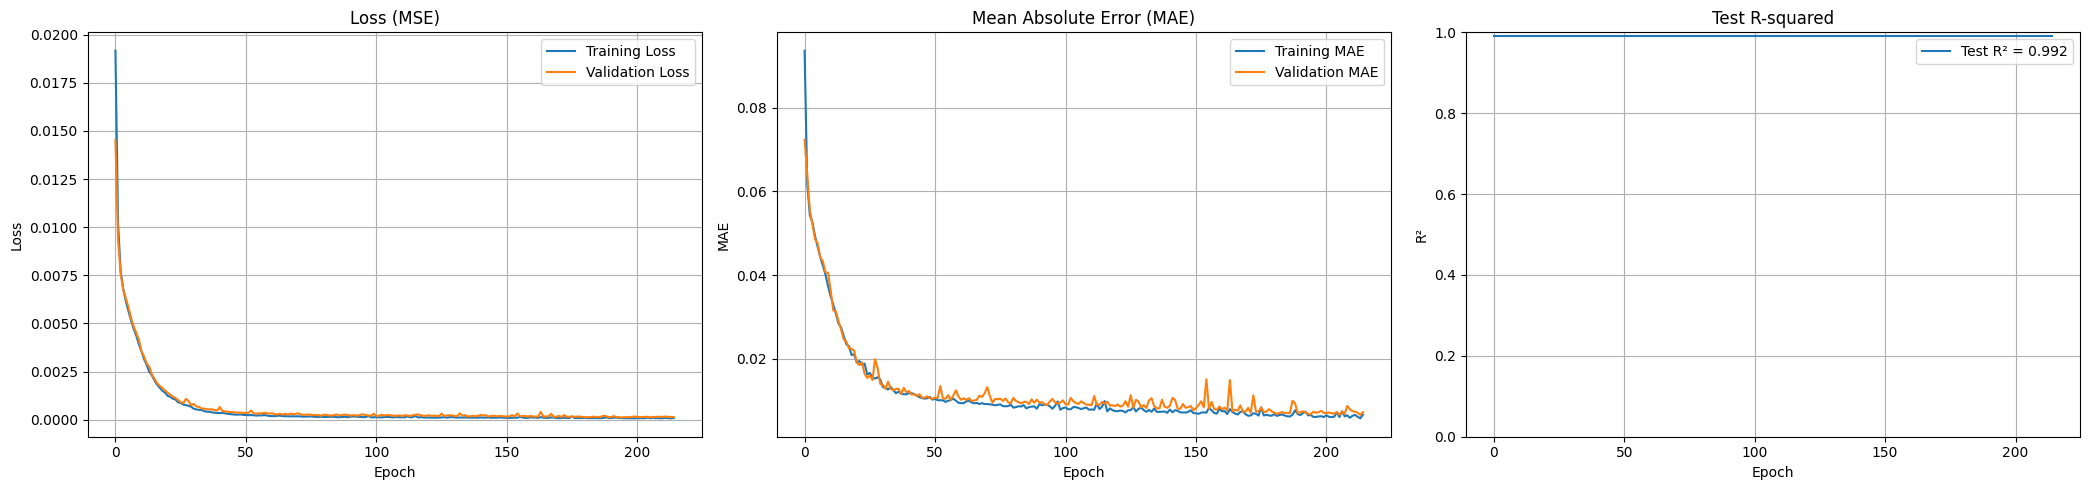

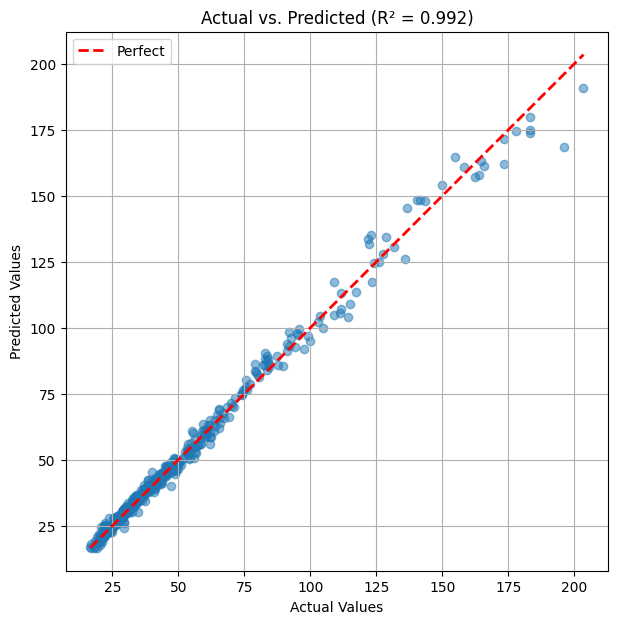

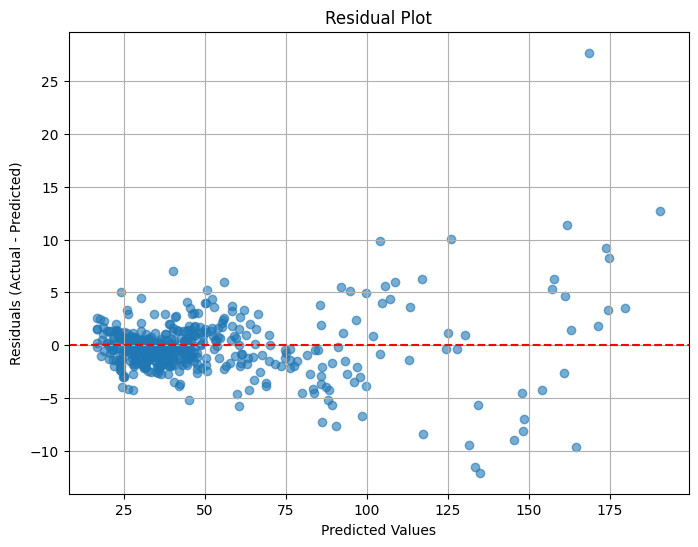


=== 최종 모델 성능 요약 ===
모델 구조: 8-32-8-1
활성화 함수: relu
최적 epoch: 195
테스트 R²: 0.9922
테스트 MAE: 0.0072


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import EarlyStopping





def create_optimal_model():
    model = Sequential([
        Input(shape=(8,)),
        Dense(optimal_units1, activation=optimal_activation),
        Dense(optimal_units2, activation=optimal_activation),
        Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    return model

ann_model = create_optimal_model() # 100 epoch 기준 최적 모델 구조 생성




print("--- 모델 학습을 시작합니다 ---")  

early_stopping = EarlyStopping( # 최적 모델 학습 (Training)
    monitor='val_loss',         # 검증 손실 기준 = val_loss = validation set의 RMSE
    patience=20,                # 개선되지 않는 epoch 20회 동안 기다리기(8~20 추천)
    restore_best_weights=True   # 가장 좋은 가중치로 복원
)


history = ann_model.fit(
    X_train_scaled, 
    Y_train_scaled,
    epochs=1000, #충분히 큰 값으로 설정
    batch_size=optimal_batch_size, #  # GridSearchCV 결과 활용 --- 아까 32라고 정의
    validation_data=(X_val_scaled, Y_val_scaled),
    callbacks=[early_stopping],  # callback 중 1개인 Early_stopping 이용/ overfitting 뜨기 전에 earlystopping 으로 끊기
    verbose=0 # 각 epoch마다 진행상황 표현
)
print("\n--- 모델 학습 완료 ---")






 





# 3. 모델 성능 평가 (Evaluation)
print("\n--- 테스트 데이터 이용 모델 성능 평가 ---")
test_loss, test_mae = ann_model.evaluate(X_test_scaled, Y_test_scaled, verbose=0) # evaluate 함수 이용 / verbose = 0 이라 평과과정 출력 X / model을 compile 할 떄 정의한 loss 와 metrics 출력
print(f"테스트 데이터 손실 (MSE): {test_loss:.4f}")
print(f"테스트 데이터 평균 절대 오차 (MAE): {test_mae:.4f}")




# 예측한 값 출력
Y_pred_scaled = ann_model.predict(X_test_scaled)   # predict(입력변수) 함수는 모델의 출력값(예측값) 출력
Y_pred = scaler_y.inverse_transform(Y_pred_scaled) # 역변환을 통해 Y_pred를 구함
Y_test_true = y_test          # 가독성을 위해...




# 상관계수 R^2 출력
r2 = r2_score(Y_test_true, Y_pred)   # r2_score 함수를 이용해 결정계수 R^2을 구함
print(f"테스트 데이터 결정계수 (R²): {r2:.4f}")  # r2를 소수점 뒤에 4자리까지만 출력


# best_epoch 출력 + 최소 val_loss 출력
best_epoch = np.argmin(history.history['val_loss']) + 1  # 가장 val_loss 가 낮았던 epoch 수를 찾기 // np.argmin 함수는 리스트에서 가장 작은 값의 인덱스(위치) 출력
print(f"최적의 epoch: {best_epoch}")                      # 위에 것을 이어 쓰자면 model.fit.history이다. 뒤의 .history를 통해 모든 훈련과정의 기록(log)를 출력 // 그 중 val_loss 만 뽑아서 보기 -- 그 중 가장 작은 값의 인덱스 출력 np.argmin
print(f"최소 val_loss: {history.history['val_loss'][best_epoch-1]:.5f}") # .history에서 np.argmin까지 하면 index 번호에 자동으로 +1을 해서 인간이 보기 편하도록 출력을 해줌 --- -1 해줘서 index 번호 넣어주기








# 5. 학습 과정 시각화 (Loss, MAE, R²)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 5))   # plt.subplots(1, 3) = 1행 3열로 전체 그래프 부분 나누기  // figsize는 전체 그래프 크기 // 전체 그래프 구간을 나눠서 각각 할당해서 그릴 때 subplot 이용

# ax1 = 첫번쨰 그림판 --  Loss 그래프 그리기
ax1.plot(history.history['loss'], label='Training Loss')   # 참고로 history = model.fit() 이라고 앞에서 정의를 해놓음 // 범례(legend)를 Training loss 라 이름지음
ax1.plot(history.history['val_loss'], label='Validation Loss')  # model.fit이 진행될때마다 loss 와 val_loss를 그리기
ax1.set_title('Loss (MSE)')  # set_title = 그래프 제목
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True) # .legend() --- 아까 label로 이름 붙여놓은 애들 표시 // .grid(True) -- 격자무늬 추가


# ax2 = MAE
ax2.plot(history.history['mean_absolute_error'], label='Training MAE')   # 아까 model.compile 할 떄 MAE 미리 선언함
ax2.plot(history.history['val_mean_absolute_error'], label='Validation MAE')  # Keras는 자동으로 validation set의 키 값 앞에 접두사 val_을 붙여준다
ax2.set_title('Mean Absolute Error (MAE)')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('MAE'); ax2.legend(); ax2.grid(True)

# ax3 = R² 수기계산(별도 그래프)
ax3.plot([r2]*len(history.history['loss']), label=f'Test R² = {r2:.3f}') # r2를 총 epoch 수만큼 만듦 -- 그래프 직선형으로 그리려고
ax3.set_title('Test R-squared')
ax3.set_xlabel('Epoch'); ax3.set_ylabel('R²'); ax3.legend(); ax3.grid(True)
ax3.set_ylim(bottom=0, top=1)

plt.tight_layout() # layout 자동으로 깔끔하게 그래프 보여줌
plt.show()  # 화면에 그래프 출력









# 6. 실제값-예측값 산점도
plt.figure(figsize=(7,7))
plt.scatter(Y_test_true, Y_pred, alpha=0.5) # alpha는 투명도를 의미 .scatter()을 통해 산점도 그리기 . x 값은 실제값 y 값은 예측값

# y = x 기준선 그리기
plt.plot([Y_test_true.min(), Y_test_true.max()],  # 선의 시작과 끝점 x좌표 
         [Y_test_true.min(), Y_test_true.max()], 'r--', lw=2, label='Perfect') # 선의 시작과 끝점 y좌표 --- x좌표와 같으므로 y = x 그래프를 그린다  # lw = linewidth = 선 굵기
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs. Predicted (R² = {r2:.3f})")
plt.legend(); plt.grid(True); plt.axis('equal') #plt.axis('equal')을 통해 y=x에 
plt.show()



# 7. 잔차 플롯 (residuals)
residuals = (Y_test_true.flatten() - Y_pred.flatten())   # residuals = 실제값 - 예측값
plt.figure(figsize=(8,6))    # 그래프 크기
plt.scatter(Y_pred, residuals, alpha=0.6)  # x축 값 = 예측값, y축 값 = (실제값- 예측값)
plt.axhline(0, color='red', linestyle='--') # axhline = 수평선(Axis Horizontal Line)**을 그리는 함수
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True) # 뒤에 격자 표시
plt.show()



# 모델 성능 요약 
print(f"\n=== 최종 모델 성능 요약 ===")
print(f"모델 구조: 8-{optimal_units1}-{optimal_units2}-1")
print(f"활성화 함수: {optimal_activation}")
print(f"최적 epoch: {best_epoch}")
print(f"테스트 R²: {r2:.4f}")
print(f"테스트 MAE: {test_mae:.4f}")

SHAP 이용 분석 시작

1. SHAP 분석을 위한 Explainer 생성

In [ ]:
from sklearn.model_selection import train_test_split
import shap

# 1. SHAP Explainer가 사용할 배경 데이터(background data)를 준비합니다.
#    훈련 데이터셋(X_train_scaled)의 특성을 대표하도록 100개의 데이터를 요약(kmeans)합니다.
#    이는 계산 효율성을 위해 필수적인 과정입니다.
print("배경 데이터셋을 생성합니다. (시간이 조금 걸릴 수 있습니다)")
background_data = shap.kmeans(X_train_scaled, 100)
print("배경 데이터셋 생성 완료!")




# 2. MLP 모델(ann_model)을 해석할 KernelExplainer를 생성합니다.
#    - 첫 번째 인자: 모델의 예측 함수(ann_model.predict)를 전달합니다.
#    - 두 번째 인자: 위에서 만든 배경 데이터를 전달합니다.
print("SHAP KernelExplainer를 생성합니다...")
explainer = shap.KernelExplainer(ann_model.predict, background_data) 
print("Explainer 생성 완료!")

# 생성된 explainer 객체 확인
print("\nExplainer 객체 정보:")
print(explainer)


배경 데이터셋을 생성합니다. (시간이 조금 걸릴 수 있습니다)
배경 데이터셋 생성 완료!
SHAP KernelExplainer를 생성합니다...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Explainer 생성 완료!

Explainer 객체 정보:


2. SHAP값 계산 ---- 시간 매우 오래 걸림!!!

In [ ]:
# Step 8. SHAP 값 계산
# KernelExplainer는 계산에 시간이 많이 소요된다!! 

print("SHAP 값 계산을 시작합니다. (시간이 몇 분 정도 소요될 수 있습니다)")
# 테스트 데이터셋(X_test_scaled)에 대한 SHAP 값을 계산합니다.
shap_values = explainer.shap_values(X_test_scaled)  # 학습과정 안보고 싶으면 여기다가 , silent = True 붙이기
print("SHAP 값 계산 완료!")

# 계산된 SHAP 값의 형태(shape) 확인
print(f"\n계산된 SHAP 값의 형태: {shap_values.shape}")


SHAP 값 계산을 시작합니다. (시간이 몇 분 정도 소요될 수 있습니다)


  0%|          | 0/476 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


  0%|          | 1/476 [00:01<14:10,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


  0%|          | 2/476 [00:03<12:18,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step


  1%|          | 3/476 [00:03<09:20,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step


  1%|          | 4/476 [00:04<07:42,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step


  1%|          | 5/476 [00:05<06:42,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step


  1%|▏         | 6/476 [00:05<06:06,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step


  1%|▏         | 7/476 [00:06<05:48,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step


  2%|▏         | 8/476 [00:07<05:29,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step


  2%|▏         | 9/476 [00:07<05:27,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step


  2%|▏         | 10/476 [00:08<05:17,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step


  2%|▏         | 11/476 [00:09<05:08,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step


  3%|▎         | 12/476 [00:09<05:09,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step


  3%|▎         | 13/476 [00:10<05:14,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step


  3%|▎         | 14/476 [00:11<05:08,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step


  3%|▎         | 15/476 [00:11<05:05,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step


  3%|▎         | 16/476 [00:12<05:03,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


  4%|▎         | 17/476 [00:13<04:59,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step


  4%|▍         | 18/476 [00:13<05:00,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step


  4%|▍         | 19/476 [00:14<04:56,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step


  4%|▍         | 20/476 [00:14<04:54,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step


  4%|▍         | 21/476 [00:15<04:49,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step


  5%|▍         | 22/476 [00:16<04:48,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step


  5%|▍         | 23/476 [00:16<04:49,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step


  5%|▌         | 24/476 [00:17<04:46,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step


  5%|▌         | 25/476 [00:18<04:45,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step


  5%|▌         | 26/476 [00:18<04:48,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step


  6%|▌         | 27/476 [00:19<04:50,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step


  6%|▌         | 28/476 [00:20<04:52,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step


  6%|▌         | 29/476 [00:20<04:50,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step


  6%|▋         | 30/476 [00:21<04:52,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step


  7%|▋         | 31/476 [00:22<04:52,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step


  7%|▋         | 32/476 [00:22<04:53,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step


  7%|▋         | 33/476 [00:23<04:51,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step


  7%|▋         | 34/476 [00:24<05:07,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step


  7%|▋         | 35/476 [00:24<05:05,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step


  8%|▊         | 36/476 [00:25<04:58,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step


  8%|▊         | 37/476 [00:26<04:59,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step


  8%|▊         | 38/476 [00:26<05:00,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step


  8%|▊         | 39/476 [00:27<04:53,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step


  8%|▊         | 40/476 [00:28<04:49,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step


  9%|▊         | 41/476 [00:29<05:22,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


  9%|▉         | 42/476 [00:30<06:50,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


  9%|▉         | 43/476 [00:31<07:50,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


  9%|▉         | 44/476 [00:33<08:37,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


  9%|▉         | 45/476 [00:35<10:12,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step


 10%|▉         | 46/476 [00:36<09:57,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step


 10%|▉         | 47/476 [00:37<09:38,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 10%|█         | 48/476 [00:39<09:31,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 10%|█         | 49/476 [00:40<09:47,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 11%|█         | 50/476 [00:41<09:27,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step


 11%|█         | 51/476 [00:42<07:57,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


 11%|█         | 52/476 [00:43<07:04,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step


 11%|█         | 53/476 [00:43<06:19,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step


 11%|█▏        | 54/476 [00:44<05:49,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step


 12%|█▏        | 55/476 [00:45<05:27,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step


 12%|█▏        | 56/476 [00:45<05:08,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step


 12%|█▏        | 57/476 [00:46<04:58,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step


 12%|█▏        | 58/476 [00:47<04:55,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step


 12%|█▏        | 59/476 [00:47<04:53,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step


 13%|█▎        | 60/476 [00:48<04:47,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step


 13%|█▎        | 61/476 [00:49<04:33,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step


 13%|█▎        | 62/476 [00:49<04:29,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step


 13%|█▎        | 63/476 [00:50<04:20,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step


 13%|█▎        | 64/476 [00:51<04:33,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step


 14%|█▎        | 65/476 [00:51<04:43,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step


 14%|█▍        | 66/476 [00:52<04:37,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step


 14%|█▍        | 67/476 [00:53<04:38,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step


 14%|█▍        | 68/476 [00:53<04:44,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 14%|█▍        | 69/476 [00:54<04:49,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 15%|█▍        | 70/476 [00:55<04:50,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step


 15%|█▍        | 71/476 [00:56<04:50,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step


 15%|█▌        | 72/476 [00:56<04:52,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 15%|█▌        | 73/476 [00:57<04:54,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 634us/step


 16%|█▌        | 74/476 [00:58<05:04,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step


 16%|█▌        | 75/476 [00:59<04:57,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 16%|█▌        | 76/476 [00:59<04:56,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


 16%|█▌        | 77/476 [01:00<04:59,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step


 16%|█▋        | 78/476 [01:01<04:50,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


 17%|█▋        | 79/476 [01:02<04:37,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step


 17%|█▋        | 80/476 [01:02<04:31,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step


 17%|█▋        | 81/476 [01:03<04:29,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step


 17%|█▋        | 82/476 [01:03<04:24,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step


 17%|█▋        | 83/476 [01:04<04:23,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step


 18%|█▊        | 84/476 [01:05<05:05,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


 18%|█▊        | 85/476 [01:06<05:57,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


 18%|█▊        | 86/476 [01:08<06:52,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 18%|█▊        | 87/476 [01:10<08:21,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 18%|█▊        | 88/476 [01:11<08:53,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 19%|█▊        | 89/476 [01:13<09:08,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 19%|█▉        | 90/476 [01:14<09:26,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


 19%|█▉        | 91/476 [01:16<08:53,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 615us/step


 19%|█▉        | 92/476 [01:16<07:40,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step


 20%|█▉        | 93/476 [01:17<06:42,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step


 20%|█▉        | 94/476 [01:18<05:57,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step


 20%|█▉        | 95/476 [01:18<05:24,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step


 20%|██        | 96/476 [01:19<04:56,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step


 20%|██        | 97/476 [01:20<04:42,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step


 21%|██        | 98/476 [01:20<04:44,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step


 21%|██        | 99/476 [01:21<04:38,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


 21%|██        | 100/476 [01:22<04:32,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step


 21%|██        | 101/476 [01:22<04:16,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step


 21%|██▏       | 102/476 [01:23<04:12,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step


 22%|██▏       | 103/476 [01:24<04:09,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step


 22%|██▏       | 104/476 [01:24<04:07,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step


 22%|██▏       | 105/476 [01:25<04:03,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step


 22%|██▏       | 106/476 [01:26<04:01,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step


 22%|██▏       | 107/476 [01:26<04:00,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step


 23%|██▎       | 108/476 [01:27<04:07,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step


 23%|██▎       | 109/476 [01:28<04:00,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step


 23%|██▎       | 110/476 [01:28<03:56,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step


 23%|██▎       | 111/476 [01:29<03:52,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step


 24%|██▎       | 112/476 [01:29<03:52,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step


 24%|██▎       | 113/476 [01:30<03:49,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step


 24%|██▍       | 114/476 [01:31<03:48,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step


 24%|██▍       | 115/476 [01:31<03:53,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step


 24%|██▍       | 116/476 [01:32<03:48,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step


 25%|██▍       | 117/476 [01:33<03:46,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step


 25%|██▍       | 118/476 [01:33<03:43,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step


 25%|██▌       | 119/476 [01:34<03:45,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step


 25%|██▌       | 120/476 [01:34<03:43,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step


 25%|██▌       | 121/476 [01:35<03:45,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step


 26%|██▌       | 122/476 [01:36<03:43,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step


 26%|██▌       | 123/476 [01:36<03:40,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step


 26%|██▌       | 124/476 [01:37<03:36,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step


 26%|██▋       | 125/476 [01:38<03:36,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step


 26%|██▋       | 126/476 [01:38<03:58,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step


 27%|██▋       | 127/476 [01:39<03:55,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step


 27%|██▋       | 128/476 [01:40<03:51,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step


 27%|██▋       | 129/476 [01:40<03:48,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step


 27%|██▋       | 130/476 [01:41<03:45,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step


 28%|██▊       | 131/476 [01:42<03:44,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step


 28%|██▊       | 132/476 [01:42<03:48,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


 28%|██▊       | 133/476 [01:43<03:44,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step


 28%|██▊       | 134/476 [01:44<03:45,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


 28%|██▊       | 135/476 [01:44<03:43,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step


 29%|██▊       | 136/476 [01:45<03:42,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step


 29%|██▉       | 137/476 [01:46<03:42,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step


 29%|██▉       | 138/476 [01:46<03:44,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


 29%|██▉       | 139/476 [01:47<03:48,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step


 29%|██▉       | 140/476 [01:48<03:45,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step


 30%|██▉       | 141/476 [01:48<03:46,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step


 30%|██▉       | 142/476 [01:49<03:43,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step


 30%|███       | 143/476 [01:50<03:40,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step


 30%|███       | 144/476 [01:50<03:38,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step


 30%|███       | 145/476 [01:51<03:37,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step


 31%|███       | 146/476 [01:52<03:44,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step


 31%|███       | 147/476 [01:52<03:44,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step


 31%|███       | 148/476 [01:53<03:41,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


 31%|███▏      | 149/476 [01:54<03:45,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step


 32%|███▏      | 150/476 [01:54<03:48,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step


 32%|███▏      | 151/476 [01:55<03:43,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step


 32%|███▏      | 152/476 [01:56<03:41,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step


 32%|███▏      | 153/476 [01:56<03:35,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step


 32%|███▏      | 154/476 [01:57<03:28,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step


 33%|███▎      | 155/476 [01:58<03:27,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step


 33%|███▎      | 156/476 [01:59<03:55,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 33%|███▎      | 157/476 [02:00<05:02,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 33%|███▎      | 158/476 [02:02<06:03,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 33%|███▎      | 159/476 [02:03<06:41,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 34%|███▎      | 160/476 [02:05<07:05,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 34%|███▍      | 161/476 [02:06<07:30,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 998us/step


 34%|███▍      | 162/476 [02:08<07:12,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 34%|███▍      | 163/476 [02:09<07:13,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 34%|███▍      | 164/476 [02:11<07:22,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 35%|███▍      | 165/476 [02:12<07:37,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step


 35%|███▍      | 166/476 [02:13<07:19,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 35%|███▌      | 167/476 [02:15<07:23,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 35%|███▌      | 168/476 [02:16<07:25,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 36%|███▌      | 169/476 [02:18<07:36,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 36%|███▌      | 170/476 [02:20<08:02,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 36%|███▌      | 171/476 [02:21<08:08,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 36%|███▌      | 172/476 [02:23<08:01,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 36%|███▋      | 173/476 [02:24<07:56,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 37%|███▋      | 174/476 [02:26<07:56,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 947us/step


 37%|███▋      | 175/476 [02:27<07:22,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step


 37%|███▋      | 176/476 [02:28<06:52,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 37%|███▋      | 177/476 [02:30<07:21,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 37%|███▋      | 178/476 [02:32<07:21,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 38%|███▊      | 179/476 [02:33<07:18,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


 38%|███▊      | 180/476 [02:34<06:56,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 38%|███▊      | 181/476 [02:36<07:21,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 38%|███▊      | 182/476 [02:38<07:38,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 38%|███▊      | 183/476 [02:39<07:13,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


 39%|███▊      | 184/476 [02:40<06:07,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step


 39%|███▉      | 185/476 [02:40<05:13,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step


 39%|███▉      | 186/476 [02:42<05:44,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step


 39%|███▉      | 187/476 [02:43<05:14,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 631us/step


 39%|███▉      | 188/476 [02:44<04:52,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step


 40%|███▉      | 189/476 [02:44<04:32,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step


 40%|███▉      | 190/476 [02:45<04:06,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step


 40%|████      | 191/476 [02:46<03:55,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step


 40%|████      | 192/476 [02:47<03:48,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step


 41%|████      | 193/476 [02:47<03:36,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step


 41%|████      | 194/476 [02:48<03:28,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step


 41%|████      | 195/476 [02:49<03:18,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step


 41%|████      | 196/476 [02:49<03:10,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step


 41%|████▏     | 197/476 [02:50<03:05,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step


 42%|████▏     | 198/476 [02:50<03:05,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 42%|████▏     | 199/476 [02:52<04:17,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 42%|████▏     | 200/476 [02:54<05:22,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 42%|████▏     | 201/476 [02:56<06:35,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step


 42%|████▏     | 202/476 [02:57<06:09,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 624us/step


 43%|████▎     | 203/476 [02:58<05:26,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


 43%|████▎     | 204/476 [02:59<04:51,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step


 43%|████▎     | 205/476 [02:59<04:20,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step


 43%|████▎     | 206/476 [03:00<03:58,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step


 43%|████▎     | 207/476 [03:01<03:50,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step


 44%|████▎     | 208/476 [03:01<03:31,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step


 44%|████▍     | 209/476 [03:02<03:25,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step


 44%|████▍     | 210/476 [03:03<03:34,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


 44%|████▍     | 211/476 [03:04<03:22,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 662us/step


 45%|████▍     | 212/476 [03:05<03:27,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step


 45%|████▍     | 213/476 [03:05<03:21,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step


 45%|████▍     | 214/476 [03:06<03:16,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step


 45%|████▌     | 215/476 [03:07<03:08,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step


 45%|████▌     | 216/476 [03:07<03:04,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step


 46%|████▌     | 217/476 [03:08<03:02,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


 46%|████▌     | 218/476 [03:09<03:09,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step


 46%|████▌     | 219/476 [03:09<03:01,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step


 46%|████▌     | 220/476 [03:10<02:54,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step


 46%|████▋     | 221/476 [03:11<02:55,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step


 47%|████▋     | 222/476 [03:11<02:53,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


 47%|████▋     | 223/476 [03:12<02:54,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step


 47%|████▋     | 224/476 [03:13<02:48,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step


 47%|████▋     | 225/476 [03:14<03:28,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 47%|████▋     | 226/476 [03:15<04:16,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 48%|████▊     | 227/476 [03:17<04:48,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 48%|████▊     | 228/476 [03:18<05:12,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 48%|████▊     | 229/476 [03:20<05:30,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 48%|████▊     | 230/476 [03:22<05:51,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 49%|████▊     | 231/476 [03:23<05:52,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 49%|████▊     | 232/476 [03:25<06:10,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 49%|████▉     | 233/476 [03:26<06:03,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 49%|████▉     | 234/476 [03:28<06:04,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step


 49%|████▉     | 235/476 [03:29<05:42,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 50%|████▉     | 236/476 [03:31<05:54,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 50%|████▉     | 237/476 [03:32<05:52,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step


 50%|█████     | 238/476 [03:33<05:13,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step


 50%|█████     | 239/476 [03:34<04:29,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step


 50%|█████     | 240/476 [03:34<03:52,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step


 51%|█████     | 241/476 [03:35<03:29,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step


 51%|█████     | 242/476 [03:36<03:14,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step


 51%|█████     | 243/476 [03:36<03:05,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step


 51%|█████▏    | 244/476 [03:37<02:54,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step


 51%|█████▏    | 245/476 [03:38<02:50,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step


 52%|█████▏    | 246/476 [03:38<02:46,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step


 52%|█████▏    | 247/476 [03:39<02:46,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


 52%|█████▏    | 248/476 [03:40<02:47,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 621us/step


 52%|█████▏    | 249/476 [03:41<02:56,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 614us/step


 53%|█████▎    | 250/476 [03:42<02:53,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step


 53%|█████▎    | 251/476 [03:42<02:46,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step


 53%|█████▎    | 252/476 [03:43<02:43,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step


 53%|█████▎    | 253/476 [03:44<02:33,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step


 53%|█████▎    | 254/476 [03:44<02:30,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step


 54%|█████▎    | 255/476 [03:45<02:27,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step


 54%|█████▍    | 256/476 [03:45<02:22,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step


 54%|█████▍    | 257/476 [03:46<02:21,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step


 54%|█████▍    | 258/476 [03:47<02:20,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 54%|█████▍    | 259/476 [03:48<02:59,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 55%|█████▍    | 260/476 [03:50<03:46,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 55%|█████▍    | 261/476 [03:51<04:20,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 55%|█████▌    | 262/476 [03:53<04:40,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 55%|█████▌    | 263/476 [03:54<04:49,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


 55%|█████▌    | 264/476 [03:55<04:44,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 56%|█████▌    | 265/476 [03:57<05:14,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 56%|█████▌    | 266/476 [03:59<05:12,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 56%|█████▌    | 267/476 [04:00<05:11,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 56%|█████▋    | 268/476 [04:02<05:04,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 57%|█████▋    | 269/476 [04:03<04:55,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 57%|█████▋    | 270/476 [04:04<04:51,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 57%|█████▋    | 271/476 [04:06<04:40,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step


 57%|█████▋    | 272/476 [04:07<04:27,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 57%|█████▋    | 273/476 [04:08<04:32,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 58%|█████▊    | 274/476 [04:10<04:37,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step


 58%|█████▊    | 275/476 [04:10<03:56,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step


 58%|█████▊    | 276/476 [04:11<03:23,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step


 58%|█████▊    | 277/476 [04:12<02:58,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step


 58%|█████▊    | 278/476 [04:12<02:43,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


 59%|█████▊    | 279/476 [04:13<02:36,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step


 59%|█████▉    | 280/476 [04:14<02:30,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step


 59%|█████▉    | 281/476 [04:14<02:24,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step


 59%|█████▉    | 282/476 [04:15<02:18,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step


 59%|█████▉    | 283/476 [04:16<02:15,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


 60%|█████▉    | 284/476 [04:16<02:15,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


 60%|█████▉    | 285/476 [04:17<02:17,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


 60%|██████    | 286/476 [04:18<02:19,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step


 60%|██████    | 287/476 [04:19<02:14,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step


 61%|██████    | 288/476 [04:19<02:09,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step


 61%|██████    | 289/476 [04:20<02:11,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


 61%|██████    | 290/476 [04:21<02:10,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step


 61%|██████    | 291/476 [04:21<02:04,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step


 61%|██████▏   | 292/476 [04:22<02:00,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step


 62%|██████▏   | 293/476 [04:23<01:59,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step


 62%|██████▏   | 294/476 [04:23<01:57,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step


 62%|██████▏   | 295/476 [04:24<01:57,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step


 62%|██████▏   | 296/476 [04:24<01:54,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step


 62%|██████▏   | 297/476 [04:25<01:53,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step


 63%|██████▎   | 298/476 [04:26<01:52,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step


 63%|██████▎   | 299/476 [04:26<01:50,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step


 63%|██████▎   | 300/476 [04:27<01:50,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step


 63%|██████▎   | 301/476 [04:28<01:49,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step


 63%|██████▎   | 302/476 [04:28<01:48,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step


 64%|██████▎   | 303/476 [04:29<01:50,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step


 64%|██████▍   | 304/476 [04:29<01:48,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step


 64%|██████▍   | 305/476 [04:30<01:48,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step


 64%|██████▍   | 306/476 [04:31<01:49,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step


 64%|██████▍   | 307/476 [04:31<01:46,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


 65%|██████▍   | 308/476 [04:32<01:46,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


 65%|██████▍   | 309/476 [04:33<01:46,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step


 65%|██████▌   | 310/476 [04:33<01:45,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step


 65%|██████▌   | 311/476 [04:34<01:45,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step


 66%|██████▌   | 312/476 [04:35<01:42,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step


 66%|██████▌   | 313/476 [04:35<01:41,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step


 66%|██████▌   | 314/476 [04:36<01:39,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step


 66%|██████▌   | 315/476 [04:36<01:40,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step


 66%|██████▋   | 316/476 [04:37<01:38,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step


 67%|██████▋   | 317/476 [04:38<01:39,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


 67%|██████▋   | 318/476 [04:38<01:38,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step


 67%|██████▋   | 319/476 [04:39<01:38,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step


 67%|██████▋   | 320/476 [04:40<01:39,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step


 67%|██████▋   | 321/476 [04:40<01:38,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step


 68%|██████▊   | 322/476 [04:41<01:39,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step


 68%|██████▊   | 323/476 [04:42<01:44,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step


 68%|██████▊   | 324/476 [04:43<01:58,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


 68%|██████▊   | 325/476 [04:45<02:53,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 68%|██████▊   | 326/476 [04:46<03:07,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step


 69%|██████▊   | 327/476 [04:47<03:06,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 69%|██████▉   | 328/476 [04:49<03:23,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 69%|██████▉   | 329/476 [04:51<03:52,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 69%|██████▉   | 330/476 [04:53<03:45,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 70%|██████▉   | 331/476 [04:54<03:49,  1.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 70%|██████▉   | 332/476 [04:56<03:54,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 70%|██████▉   | 333/476 [04:58<03:53,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 70%|███████   | 334/476 [04:59<03:49,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step


 70%|███████   | 335/476 [05:00<03:24,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step


 71%|███████   | 336/476 [05:01<03:07,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 71%|███████   | 337/476 [05:03<03:08,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step


 71%|███████   | 338/476 [05:04<03:05,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step


 71%|███████   | 339/476 [05:05<02:52,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


 71%|███████▏  | 340/476 [05:08<03:54,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 72%|███████▏  | 341/476 [05:12<05:13,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 72%|███████▏  | 342/476 [05:15<06:04,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 72%|███████▏  | 343/476 [05:19<06:43,  3.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 72%|███████▏  | 344/476 [05:23<07:01,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 72%|███████▏  | 345/476 [05:26<07:16,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 73%|███████▎  | 346/476 [05:30<07:25,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 73%|███████▎  | 347/476 [05:34<07:34,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 73%|███████▎  | 348/476 [05:37<07:35,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 73%|███████▎  | 349/476 [05:41<07:39,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 74%|███████▎  | 350/476 [05:45<07:53,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 74%|███████▎  | 351/476 [05:49<07:41,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 74%|███████▍  | 352/476 [05:52<07:40,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 74%|███████▍  | 353/476 [05:56<07:42,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


 74%|███████▍  | 354/476 [05:59<06:56,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 75%|███████▍  | 355/476 [06:00<05:40,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 75%|███████▍  | 356/476 [06:02<05:04,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 75%|███████▌  | 357/476 [06:04<04:28,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 75%|███████▌  | 358/476 [06:05<04:00,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 75%|███████▌  | 359/476 [06:07<03:34,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 76%|███████▌  | 360/476 [06:08<03:29,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 76%|███████▌  | 361/476 [06:10<03:16,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step


 76%|███████▌  | 362/476 [06:11<02:58,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step


 76%|███████▋  | 363/476 [06:12<02:46,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 76%|███████▋  | 364/476 [06:14<02:50,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step


 77%|███████▋  | 365/476 [06:15<02:40,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 77%|███████▋  | 366/476 [06:17<02:42,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 77%|███████▋  | 367/476 [06:18<02:42,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 77%|███████▋  | 368/476 [06:20<02:54,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 78%|███████▊  | 369/476 [06:22<02:56,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 78%|███████▊  | 370/476 [06:24<02:56,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step


 78%|███████▊  | 371/476 [06:25<02:47,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 78%|███████▊  | 372/476 [06:29<03:49,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 78%|███████▊  | 373/476 [06:33<04:33,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 79%|███████▊  | 374/476 [06:36<05:01,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 79%|███████▉  | 375/476 [06:40<05:21,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 79%|███████▉  | 376/476 [06:43<05:29,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 79%|███████▉  | 377/476 [06:47<05:32,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 79%|███████▉  | 378/476 [06:51<05:36,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 80%|███████▉  | 379/476 [06:54<05:38,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 80%|███████▉  | 380/476 [06:58<05:39,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 80%|████████  | 381/476 [07:01<05:36,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 80%|████████  | 382/476 [07:05<05:33,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 80%|████████  | 383/476 [07:09<05:32,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 81%|████████  | 384/476 [07:11<04:43,  3.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 81%|████████  | 385/476 [07:12<04:07,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 81%|████████  | 386/476 [07:14<03:37,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 81%|████████▏ | 387/476 [07:16<03:24,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 82%|████████▏ | 388/476 [07:18<03:04,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 82%|████████▏ | 389/476 [07:20<02:58,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 82%|████████▏ | 390/476 [07:21<02:43,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


 82%|████████▏ | 391/476 [07:23<02:44,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 82%|████████▏ | 392/476 [07:25<02:34,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step


 83%|████████▎ | 393/476 [07:26<02:14,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step


 83%|████████▎ | 394/476 [07:27<02:07,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


 83%|████████▎ | 395/476 [07:30<02:36,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 83%|████████▎ | 396/476 [07:34<03:13,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 83%|████████▎ | 397/476 [07:37<03:36,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 84%|████████▎ | 398/476 [07:41<03:52,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


 84%|████████▍ | 399/476 [07:45<04:10,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 84%|████████▍ | 400/476 [07:49<04:20,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 84%|████████▍ | 401/476 [07:52<04:13,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step


 84%|████████▍ | 402/476 [07:53<03:17,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


 85%|████████▍ | 403/476 [07:55<03:00,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


 85%|████████▍ | 404/476 [07:57<02:49,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 85%|████████▌ | 405/476 [07:59<02:31,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 85%|████████▌ | 406/476 [08:00<02:23,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


 86%|████████▌ | 407/476 [08:03<02:41,  2.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


 86%|████████▌ | 408/476 [08:07<03:12,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 86%|████████▌ | 409/476 [08:11<03:25,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 86%|████████▌ | 410/476 [08:15<03:32,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 86%|████████▋ | 411/476 [08:18<03:33,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 87%|████████▋ | 412/476 [08:22<03:35,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 87%|████████▋ | 413/476 [08:25<03:33,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 87%|████████▋ | 414/476 [08:29<03:33,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 87%|████████▋ | 415/476 [08:32<03:33,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 87%|████████▋ | 416/476 [08:36<03:29,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 88%|████████▊ | 417/476 [08:39<03:25,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 88%|████████▊ | 418/476 [08:43<03:23,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 88%|████████▊ | 419/476 [08:46<03:21,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 88%|████████▊ | 420/476 [08:50<03:18,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 88%|████████▊ | 421/476 [08:53<03:14,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 89%|████████▊ | 422/476 [08:57<03:10,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 89%|████████▉ | 423/476 [09:01<03:09,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 89%|████████▉ | 424/476 [09:04<03:07,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 89%|████████▉ | 425/476 [09:08<03:05,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 89%|████████▉ | 426/476 [09:11<03:00,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 90%|████████▉ | 427/476 [09:15<02:58,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 90%|████████▉ | 428/476 [09:19<02:55,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 90%|█████████ | 429/476 [09:23<02:51,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 90%|█████████ | 430/476 [09:26<02:45,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 91%|█████████ | 431/476 [09:30<02:41,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 91%|█████████ | 432/476 [09:33<02:37,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 91%|█████████ | 433/476 [09:37<02:33,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 91%|█████████ | 434/476 [09:40<02:30,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 91%|█████████▏| 435/476 [09:44<02:27,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 92%|█████████▏| 436/476 [09:47<02:23,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 92%|█████████▏| 437/476 [09:51<02:17,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 92%|█████████▏| 438/476 [09:55<02:15,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 92%|█████████▏| 439/476 [09:58<02:10,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 92%|█████████▏| 440/476 [10:01<02:06,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 93%|█████████▎| 441/476 [10:05<02:02,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 93%|█████████▎| 442/476 [10:08<01:58,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 93%|█████████▎| 443/476 [10:12<01:55,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 93%|█████████▎| 444/476 [10:15<01:52,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 93%|█████████▎| 445/476 [10:19<01:47,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 94%|█████████▎| 446/476 [10:24<02:03,  4.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 94%|█████████▍| 447/476 [10:28<01:54,  3.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 94%|█████████▍| 448/476 [10:31<01:46,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 94%|█████████▍| 449/476 [10:35<01:41,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 95%|█████████▍| 450/476 [10:39<01:36,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 95%|█████████▍| 451/476 [10:42<01:31,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 95%|█████████▍| 452/476 [10:46<01:27,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 95%|█████████▌| 453/476 [10:49<01:23,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 95%|█████████▌| 454/476 [10:53<01:20,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 96%|█████████▌| 455/476 [10:57<01:16,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 96%|█████████▌| 456/476 [11:00<01:13,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 96%|█████████▌| 457/476 [11:04<01:10,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 96%|█████████▌| 458/476 [11:08<01:07,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


 96%|█████████▋| 459/476 [11:12<01:05,  3.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 97%|█████████▋| 460/476 [11:16<01:01,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 97%|█████████▋| 461/476 [11:20<00:57,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 97%|█████████▋| 462/476 [11:24<00:53,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 97%|█████████▋| 463/476 [11:27<00:48,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 97%|█████████▋| 464/476 [11:31<00:44,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 98%|█████████▊| 465/476 [11:35<00:41,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


 98%|█████████▊| 466/476 [11:39<00:37,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


 98%|█████████▊| 467/476 [11:43<00:34,  3.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 98%|█████████▊| 468/476 [11:46<00:30,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 99%|█████████▊| 469/476 [11:50<00:26,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 99%|█████████▊| 470/476 [11:54<00:23,  3.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 99%|█████████▉| 471/476 [11:58<00:19,  3.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 99%|█████████▉| 472/476 [12:02<00:15,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 99%|█████████▉| 473/476 [12:05<00:11,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


100%|█████████▉| 474/476 [12:09<00:07,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


100%|█████████▉| 475/476 [12:13<00:03,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


100%|██████████| 476/476 [12:16<00:00,  1.55s/it]

SHAP 값 계산 완료!

계산된 SHAP 값의 형태: (476, 8, 1)


Explanation 객체 만들기

In [17]:
# 앞에서 오랜시간동안 계산된 shap_values 변수 사용

print("SHAP Explanation 객체 생성")

# shap_values와 explainer.expected_value에서 [0]을 모두 제거합니다.
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test_scaled,
    feature_names=feature_names
)
print("Explanation 객체 생성 완료!")


SHAP Explanation 객체 생성
Explanation 객체 생성 완료!


Graph 1. Summary Plot

--- 진단 완료! 원인을 파악하여 최종 코드를 실행합니다 ---
1. shap_values의 형태를 (476, 8, 1)에서 (476, 8)로 수정합니다...
   => 수정된 형태(Shape): (476, 8)

2. 수정된 데이터로 SHAP Explanation 객체를 생성합니다...
   => 객체 생성 완료.

3. 올바른 객체로 Summary Plot을 생성합니다. 이번에는 정상적으로 표시될 것입니다.


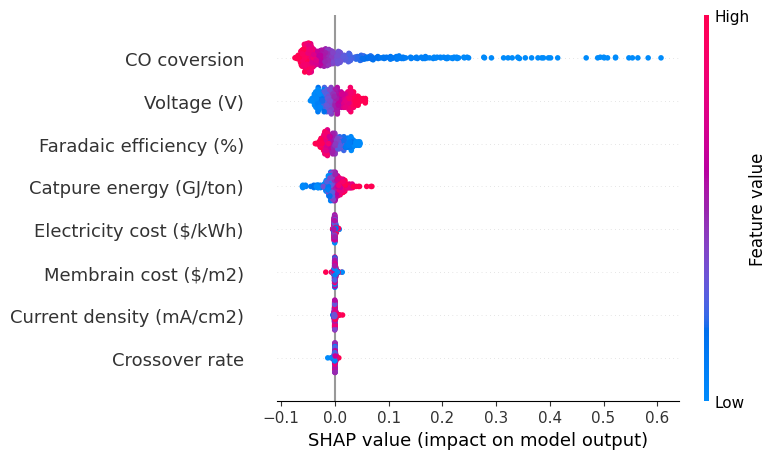

In [21]:
# [최종 해결 코드]
# 원인: shap_values의 형태가 (476, 8, 1)인 3차원 배열이었음
# 해결: numpy.squeeze() 함수로 불필요한 차원을 제거하여 (476, 8) 형태로 만듦

import numpy as np
import shap
import matplotlib.pyplot as plt

print("--- 진단 완료! 원인을 파악하여 최종 코드를 실행합니다 ---")

# 1. 문제의 원인이었던 3차원 배열(476, 8, 1)을 2차원(476, 8)으로 변환합니다.
print("1. shap_values의 형태를 (476, 8, 1)에서 (476, 8)로 수정합니다...")
shap_values_corrected = np.squeeze(shap_values)
print(f"   => 수정된 형태(Shape): {shap_values_corrected.shape}")

# 2. 수정된 배열을 사용해 SHAP Explanation 객체를 다시 생성합니다.
print("\n2. 수정된 데이터로 SHAP Explanation 객체를 생성합니다...")
shap_explanation_corrected = shap.Explanation(
    values=shap_values_corrected,
    base_values=explainer.expected_value,
    data=X_test_scaled,
    feature_names=feature_names
)
print("   => 객체 생성 완료.")

# 3. 최종적으로 수정된 객체로 Summary Plot을 생성합니다.
print("\n3. 올바른 객체로 Summary Plot을 생성합니다. 이번에는 정상적으로 표시될 것입니다.")
shap.summary_plot(shap_explanation_corrected)
plt.show()
